In [ ]:
from google.colab import drive
 
# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


This is a link to our gathered dataset of more than 500 Iraninan car images for three car models, namely peugeot 206, peugeot Pars, Pride 
[dataset_link](https://drive.google.com/drive/folders/1RnLxut1Z_iVWXA7_BU6fei0EIJ8CP1Vz?usp=sharing)

# Prequisites

In [ ]:
!pip install -U albumentations
!pip install opencv-python-headless==4.1.2.30
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import cv2
import json
from tqdm import tqdm
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import glob
import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL import Image
from os import listdir
from os.path import isfile, join
import warnings
from keras import backend as K
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from pandas.core.common import flatten
import random
import copy
import matplotlib.pyplot as plt
from collections import OrderedDict, deque
from sklearn.metrics import confusion_matrix, classification_report
import cv2 
from google.colab.patches import cv2_imshow
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

use_cuda = torch.cuda.is_available()
import shutil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 116 kB 28.8 MB/s 
     |████████████████████████████████| 48.3 MB 2.0 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.2 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


#Params
 

In [ ]:
params = {
    "batch_size": 10,
    "num_workers": 0,
    "n_epochs": 20,
    "image_size": 224, 
    "in_channels": 3, 
    "num_classes": 3
}

# Helper functions

In [ ]:
def get_classes(dataset_path):
    imagepaths, labels = list(), list()
    label = 1
    try: 
      classes = sorted(os.walk(dataset_path).next()[1])
      print(classes)
    except Exception: 
      classes = sorted(os.walk(dataset_path).__next__()[1])
    idx_to_class = {i:j for i, j in enumerate(classes)}
    class_to_idx = {value:key for key,value in idx_to_class.items()}
    return classes, idx_to_class, class_to_idx

def get_paths(path, mode = "train"):
  paths = [] #to store image paths in list
  classes = [] #to store class values

  for data_path in glob.glob(path + '/*'):
      # print(data_path)
      classes.append(data_path.split('/')[-1]) 
      paths.append(glob.glob(data_path + '/*'))
      
  paths = list(flatten(paths))
  if mode == "train":
    random.shuffle(paths)
  return paths, classes

def get_dataset_cars_path(path):
  paths = [] 
  for data_path in glob.glob(path + '/*'):
      # print(data_path) 
      paths.append(data_path)
      
  paths = list(flatten(paths))
  return paths

def get_crop_cars_path(path):
  paths = [] 
  for data_path in glob.glob(path + '/*'):
    # print(data_path) 
    paths.append(data_path)
  return paths

In [ ]:
classes, idx_to_class, class_to_idx = get_classes("/content/drive/MyDrive/final/dataset/train")
print("idx_to_class : {}".format(idx_to_class))
print("class_to_idx : {}".format(class_to_idx))

idx_to_class : {0: 'p206', 1: 'ppars', 2: 'pride'}
class_to_idx : {'p206': 0, 'ppars': 1, 'pride': 2}


# PreProcessing

In [ ]:
train_transforms = A.Compose(
    [
        # A.SmallestMaxSize(max_size=350),
        # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        # A.RandomCrop(height=224, width=224),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        A.Resize(height=224, width=224),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        # A.SmallestMaxSize(max_size=350),
        # A.CenterCrop(height=224, width=224),
        A.Resize(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
train_image_path = "/content/drive/MyDrive/final/dataset/train"
test_image_path = "/content/drive/MyDrive/final/dataset/test"
valid_image_path = "/content/drive/MyDrive/final/dataset/valid"

In [ ]:
def create_train_val_test_sets():

  train_image_paths = [] #to store image paths in list
  classes = [] #to store class values

  train_image_paths, classes = get_paths(train_image_path, "train")

  print('train_image_path example: ', train_image_paths[0])
  print('class example: ', classes[0])

  test_image_paths, _ = get_paths(test_image_path,"test")
  valid_image_paths, _ = get_paths(valid_image_path,"valid")

  print("\nTrain size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths[:480]), len(valid_image_paths[:60]), len(test_image_paths)))

  return train_image_paths[:480], valid_image_paths[:60], test_image_paths

In [ ]:
train_image_paths, valid_image_paths, test_image_paths = create_train_val_test_sets()

train_image_path example:  /content/drive/MyDrive/final/dataset/train/ppars/ppars_22.jpg
class example:  p206

Train size: 480
Valid size: 60
Test size: 60


In [ ]:
class CarDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        # print(image_filepath)
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
 
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label
    
#######################################################
#                  Create Dataset
#######################################################

train_dataset = CarDataset(train_image_paths,train_transforms)
valid_dataset = CarDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = CarDataset(test_image_paths,test_transforms)

In [ ]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[43][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[43][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 224, 224])
The label for 50th image in train dataset:  1


In [ ]:
len(train_dataset)

480

### Visualization

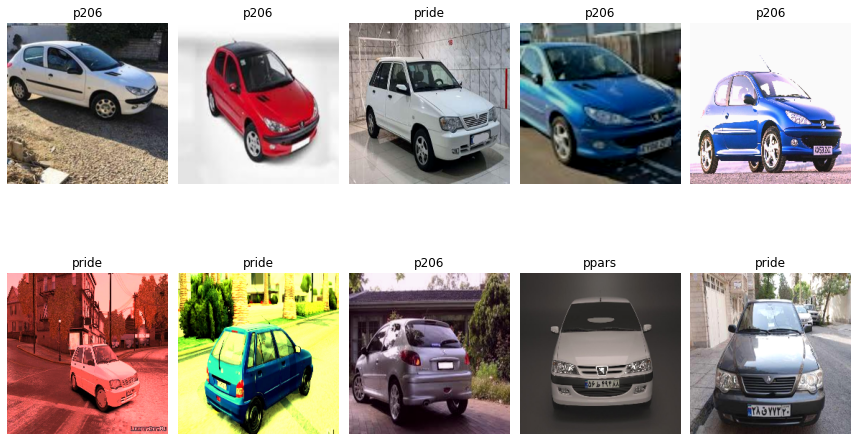

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

### Dataloader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=params["batch_size"], shuffle=True
)


test_loader = DataLoader(
    test_dataset,batch_size=params["batch_size"], shuffle=False
)

loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

In [ ]:
next(iter(test_loader))[0].shape

torch.Size([10, 3, 224, 224])

# ViT  model

## load model

In [ ]:
!pip install ml_collections
!git clone https://github.com/jeonsworld/ViT-pytorch.git
!mv ViT-pytorch/* .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 6.4 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=e78485fa30b4317ead5de34752431a3c092fe8bcc37043b6c58750beecc75533
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b705879561b715a8341a856a3bbd2
Successfully built ml-collections
Cloning into 'ViT-pytorch'...
remote: Enumerating objects: 170, done.
remote: Total 170 (delta 0), reused 0 (delta 0), pack-reused 170
Receiving objects: 100% (170/170), 21.20 MiB | 9.99 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [ ]:
from urllib.request import urlretrieve
from models.modeling import VisionTransformer, CONFIGS

os.makedirs("model_checkpoints", exist_ok=True)
if not os.path.isfile("model_checkpoints/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", 
                "model_checkpoints/ViT-B_16-224.npz")

config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True) 
model.load_from(np.load("model_checkpoints/ViT-B_16-224.npz"))

## Define model

In [ ]:
encoder = nn.Sequential(*[model.transformer.embeddings, model.transformer.encoder])
ViT_embed_dim = 768  # final embedding dimension for ViT-B
n_classes = 3        # number of classes for my dataset
classifier = nn.Linear(ViT_embed_dim, n_classes)

In [ ]:
encoder = torch.load('/content/drive/MyDrive/final/checkpoint/encoder_best_1.pt')
classifier = torch.load('/content/drive/MyDrive/final/checkpoint/classifier_best_1.pt')

## Train

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
def fine_tune_ViT(encoder,     # ViT encoder (pre-trained)
                  classifier,  # single-layer fully-connected classifier
                  train_loader,
                  valid_loader,
                  n_epochs,    # number of epochs to fine-tune
                  lr,          # learning rate
                  multi_label_data=False
                  ):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("The model will be running on", device, "device")
  encoder.to(device)
  classifier.to(device)

  #  1. Define optimizers and loss function  
  optimizer_encoder    = optim.Adam(encoder.parameters(), lr=lr, betas=(0.5, 0.9))
  optimizer_classifier = optim.Adam(classifier.parameters(), lr=lr, betas=(0.5, 0.9))
  criterion = nn.CrossEntropyLoss()

   # Early stopping
  last_loss = 100
  patience = 2
  triggertimes = 0
  
  train_losses, valid_losses, val_accs = [], [], []
  for e in range(n_epochs):
    #  2. Train on training data  
    encoder.train()
    classifier.train()
    train_loss = 0.
    for batch_i, (img, tgt) in enumerate(train_loader):
      # print(tgt)
      img, tgt = img.to(device), tgt.long().to(device)

      embeddings, att_weights = encoder(img) 

      embedding_cls_token = embeddings[:, 0, :] # [batch_size, embedding dim] 

      logits = classifier(embedding_cls_token) # [batch_size, n_classes] 
      # print(logits)
      optimizer_encoder.zero_grad()
      optimizer_classifier.zero_grad()
      loss = criterion(logits, tgt)
      loss.backward()
      optimizer_encoder.step()
      optimizer_classifier.step()
      train_loss += loss.item()
    
    n_training_batch = batch_i
    train_epoch_loss = train_loss / n_training_batch
    train_losses.append(train_epoch_loss)
    #  3. Evaluate on valdiation data  
    encoder.eval()
    classifier.eval()
    val_loss = 0.
    accuracy = 0.0
    total = 0.0
    for batch_i, (img, tgt) in enumerate(valid_loader):
      img, tgt = img.to(device), tgt.long().to(device)
      with torch.no_grad():
        embeddings, att_weights = encoder(img) # embeddings: [batch_size, n_tokens, embedding dim]
        embedding_cls_token = embeddings[:, 0, :]  # [batch_size, embedding dim]
        logits = classifier(embedding_cls_token)   # [batch_size, n_classes]
        loss = criterion(logits, tgt)
        val_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += logits.size(0)
        accuracy += (predicted == tgt).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    n_validating_batch = batch_i
    val_loss = val_loss / n_validating_batch
    valid_losses.append(val_loss)
    
    #  4. Log results and save model checkpoints 
    print("Epoch: {}/{}  Train CE Loss: {:.5f}  Val CE Loss: {:.5f}   Val  Accuracy: {:.5f}".format(e+1, n_epochs, train_loss, val_loss, accuracy))

    if val_loss > last_loss:
            trigger_times += 1
            print('The Last Loss: ', last_loss, ' The Current Loss: ',val_loss )
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!')
                return encoder, classifier

    else:
        # print('trigger times: 0')
        torch.save(encoder, '/content/drive/MyDrive/final/checkpoint/encoder_best_1.pt')
        torch.save(classifier, '/content/drive/MyDrive/final/checkpoint/classifier_best_1.pt')
        trigger_times = 0

    last_loss = val_loss
   
  plt.figure()
  plt.plot(train_losses, "ro-", label="Train")
  plt.plot(valid_losses, "go-", label="Validation")
  plt.legend()
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.savefig("/content/drive/MyDrive/final/checkpoint/training_curve.png")

  return encoder, classifier

The model will be running on cuda:0 device
Epoch: 1/20  Train CE Loss: 52.65991  Val CE Loss: 1.29614   Val  Accuracy: 43.33333
Epoch: 2/20  Train CE Loss: 46.87822  Val CE Loss: 1.21948   Val  Accuracy: 55.00000
Epoch: 3/20  Train CE Loss: 43.02768  Val CE Loss: 1.14770   Val  Accuracy: 55.00000
Epoch: 4/20  Train CE Loss: 38.90534  Val CE Loss: 1.07892   Val  Accuracy: 63.33333
Epoch: 5/20  Train CE Loss: 35.28084  Val CE Loss: 0.99855   Val  Accuracy: 68.33333
Epoch: 6/20  Train CE Loss: 31.30576  Val CE Loss: 0.93468   Val  Accuracy: 66.66667
Epoch: 7/20  Train CE Loss: 28.07754  Val CE Loss: 0.88245   Val  Accuracy: 75.00000
Epoch: 8/20  Train CE Loss: 25.89896  Val CE Loss: 0.80415   Val  Accuracy: 73.33333
Epoch: 9/20  Train CE Loss: 22.28436  Val CE Loss: 0.75197   Val  Accuracy: 80.00000
Epoch: 10/20  Train CE Loss: 19.20114  Val CE Loss: 0.70020   Val  Accuracy: 78.33333
Epoch: 11/20  Train CE Loss: 17.98044  Val CE Loss: 0.65219   Val  Accuracy: 80.00000
Epoch: 12/20  Train 

FileNotFoundError: ignored

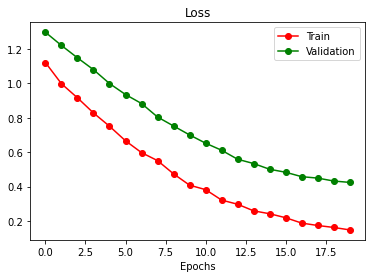

In [ ]:
encoder, classifier = fine_tune_ViT(encoder, 
                                    classifier, 
                                    train_loader,
                                    valid_loader, 
                                    n_epochs=params["n_epochs"], 
                                    lr=3e-6,)

## Predict

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
def show_images(images,predict, labels):
  fig=plt.figure(figsize=(20,20))
  for ii in range(len(images)):
      # image = to_pil(images[ii])
      pred = predict[ii]
      sub = fig.add_subplot(ii//5 + 1, 5, ii% 5 + 1)
      res = int(labels[ii]) == pred
      sub.set_title("pred is " + str(idx_to_class[pred]) + " /  real is " + str(idx_to_class[labels[ii]]))
      plt.axis('off')
      plt.imshow(np.transpose(images[ii].cpu().numpy(), (1, 2, 0)))
  plt.show()

def predict_fine_tune_ViT(encoder, 
                  classifier,
                  test_loader,
                  ):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    criterion = nn.CrossEntropyLoss()
    encoder.eval()
    classifier.eval()
    val_loss = 0.
    accuracy = 0.0
    total = 0.0
    y_pred = []
    y_true = []
    for batch_i, (img, tgt) in enumerate(test_loader):
      img, tgt = img.to(device), tgt.long().to(device)
      # print(tgt)
      with torch.no_grad():
        embeddings, att_weights = encoder(img) # embeddings: [batch_size, n_tokens, embedding dim]
        embedding_cls_token = embeddings[:, 0, :]  # [batch_size, embedding dim]
        logits = classifier(embedding_cls_token)   # [batch_size, n_classes]
        loss = criterion(logits, tgt)
        val_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        # print(predicted)
        total += logits.size(0)
        accuracy += (predicted == tgt).sum().item()
        tgt = tgt.data.cpu().numpy()
        predicted = predicted.data.cpu().numpy()
        # show_images(img, tgt, predicted)
        y_true.extend(tgt) # Save Truth
        y_pred.extend(predicted) # Save Prediction
        show_images(img,predicted, tgt)

    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    print("Test Accuracy: {:.5f}".format(accuracy))

    classes = ['p206', 'ppars', 'pride']
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix , index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')

    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    for i in range(len(y_true)):
      label = y_true[i]
      pred = y_pred[i]
      if label == pred :
        class_correct[label] += 1
      class_total[label] += 1

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))


The model will be running on cuda:0 device


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

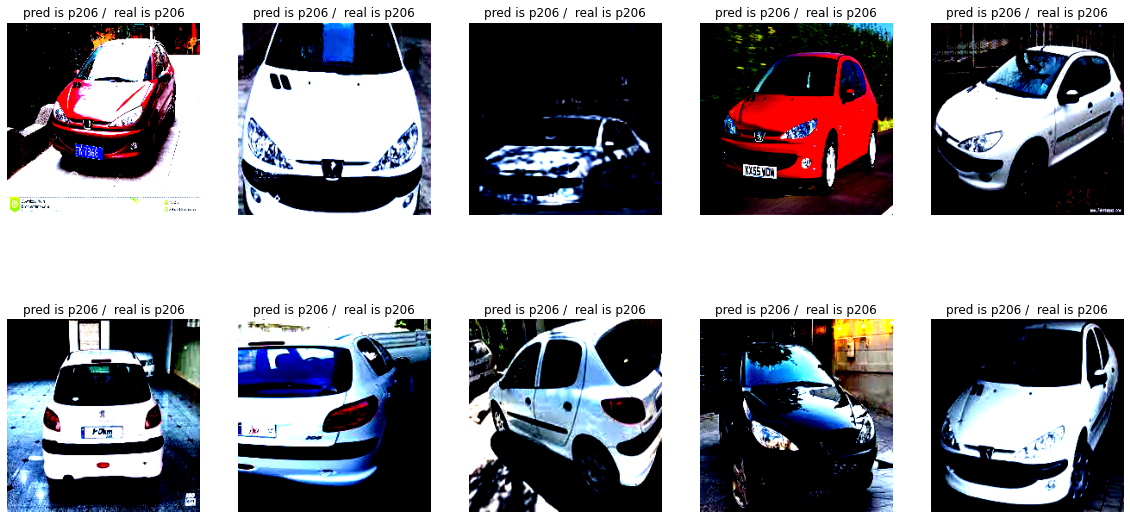

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

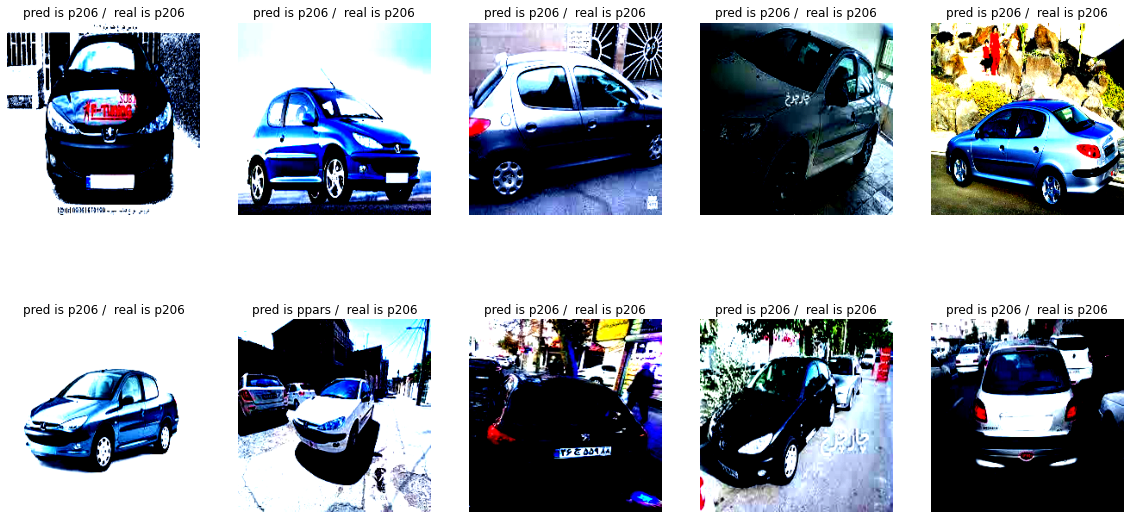

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

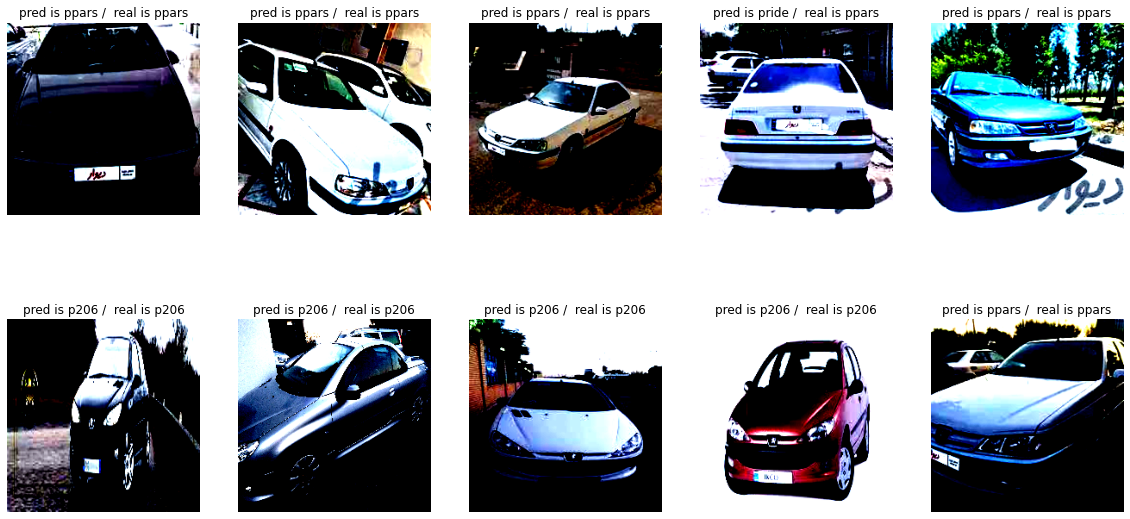

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

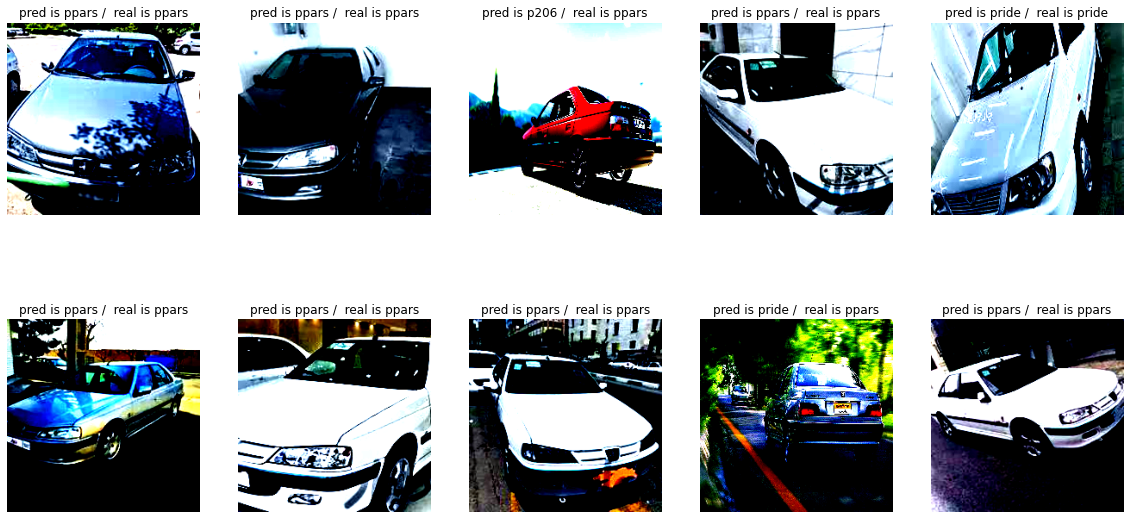

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

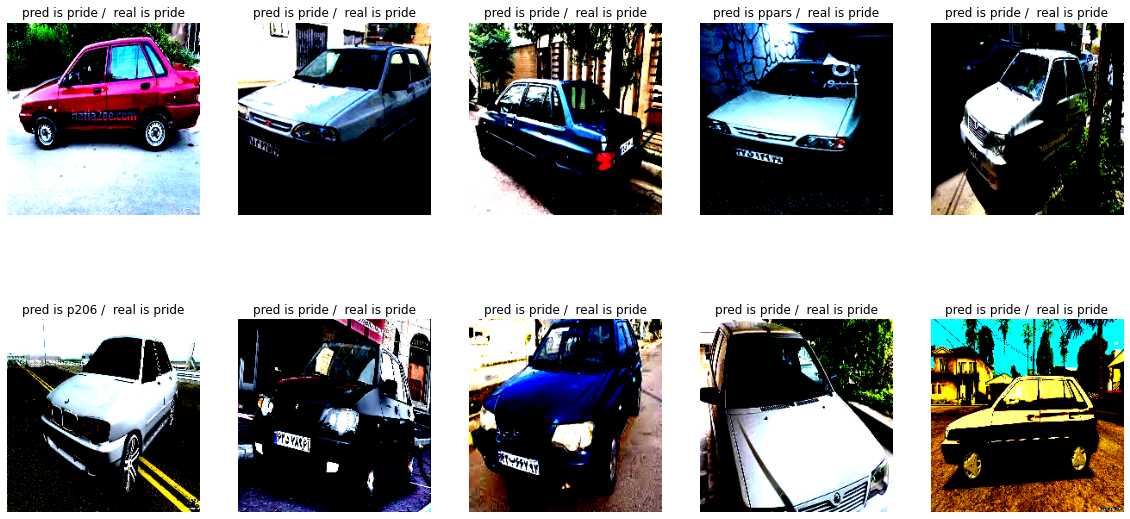

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

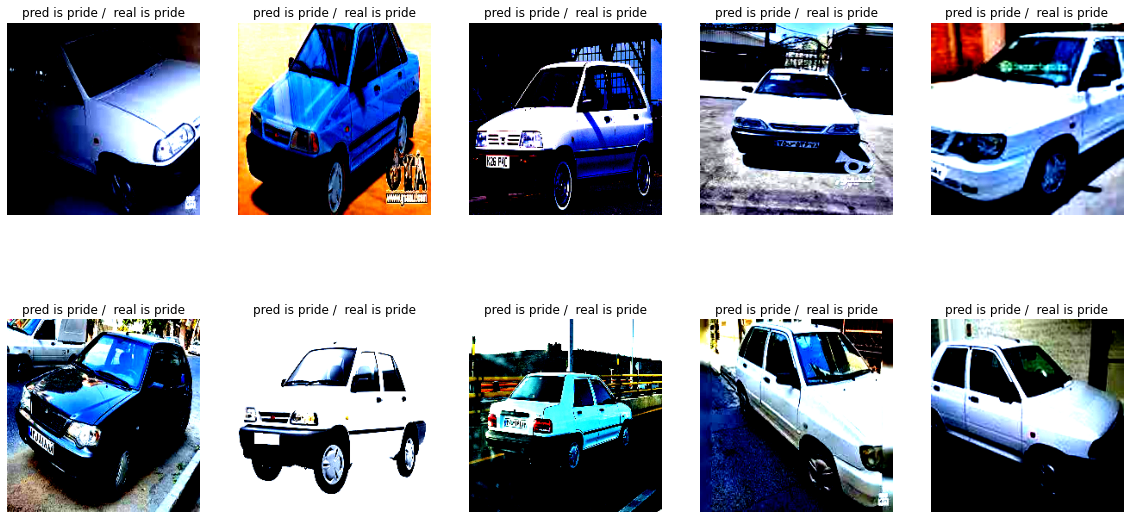

Test Accuracy: 90.00000
Accuracy of  p206 : 95 %
Accuracy of ppars : 80 %
Accuracy of pride : 90 %


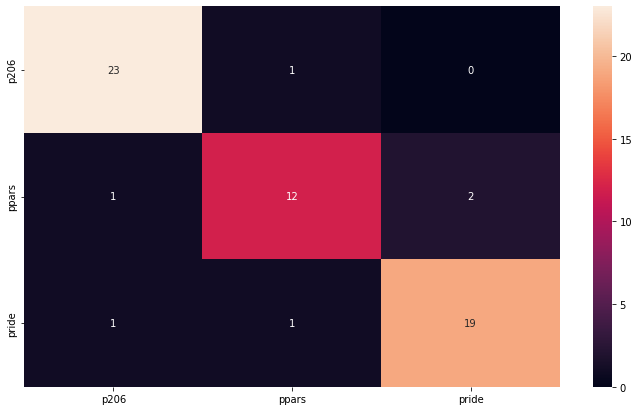

In [ ]:
predict_fine_tune_ViT(encoder, classifier, test_loader,)

# ResNet model

Transfer learning via feature extraction using resnet50 model

In [ ]:
import torchvision.models as models

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


## Load model

In [ ]:
class FineTuneModel(nn.Module):
    def __init__(self, original_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        self.classifier = nn.Sequential(
                nn.Linear(2048,num_classes)
)
            
        self.modelName = 'resnet'
            # Freeze those weights
        for p in self.features.parameters():
            p.requires_grad = False


    def forward(self, x):
        f = self.features(x)
        f = f.view(f.size(0), -1)
        y = self.classifier(f)
        return y

## Define model

In [ ]:
original_model = models.__dict__["resnet50"](pretrained=True)
model = FineTuneModel(original_model, 3)
model = torch.nn.DataParallel(model).to(device)

## Train

In [ ]:
def train_resnet(train_loader,valid_loader, model, n_epochs):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), # Only finetunable params
                                 0.001,
                                  momentum=0.9)
  # optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), # Only finetunable params
  #                                0.00001)
  
   # Early stopping
  last_loss = 100
  patience = 2
  triggertimes = 0
  
  train_losses, valid_losses, val_accs = [], [], []
  for e in range(n_epochs):
    #  2. Train on training data  
    encoder.train()
    classifier.train()
    train_loss = 0.
    for batch_i, (img, tgt) in enumerate(train_loader):
      # print(tgt)
      img, tgt = img.to(device), tgt.long().to(device)

      logits = model(img) 

      optimizer.zero_grad()
      loss = criterion(logits, tgt)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    
    n_training_batch = batch_i
    train_epoch_loss = train_loss / n_training_batch
    train_losses.append(train_epoch_loss)
    #  3. Evaluate on valdiation data  
    encoder.eval()
    classifier.eval()
    val_loss = 0.
    accuracy = 0.0
    total = 0.0
    for batch_i, (img, tgt) in enumerate(valid_loader):
      img, tgt = img.to(device), tgt.long().to(device)
      with torch.no_grad():
        logits = model(img)   
        loss = criterion(logits, tgt)
        val_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += logits.size(0)
        accuracy += (predicted == tgt).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    n_validating_batch = batch_i
    val_loss = val_loss / n_validating_batch
    valid_losses.append(val_loss)
    
    #  4. Log results and save model checkpoints 
    print("Epoch: {}/{}  Train CE Loss: {:.5f}  Val CE Loss: {:.5f}   Val  Accuracy: {:.5f}".format(e+1, n_epochs, train_loss, val_loss, accuracy))

    if val_loss > last_loss:
            trigger_times += 1
            print('The Last Loss: ', last_loss, ' The Current Loss: ',val_loss )
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!')
                return model

    else:
        # print('trigger times: 0')
        torch.save(model, '/content/drive/MyDrive/final/checkpoint/resnet_best_4_50.pt')
        # torch.save(model, '/content/drive/MyDrive/final/checkpoint/resnet_best_4_scratch.pt')
        trigger_times = 0

    last_loss = val_loss
  
   
  plt.figure()
  plt.plot(train_losses, "ro-", label="Train")
  plt.plot(valid_losses, "go-", label="Validation")
  plt.legend()
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.savefig("/content/drive/MyDrive/final/checkpoint/training_curve_resnet.png")

  return model

### transfer version

In [ ]:
resnet_model = train_resnet(train_loader,valid_loader, model, 30)

Epoch: 1/30  Train CE Loss: 50.50120  Val CE Loss: 1.30693   Val  Accuracy: 41.66667
Epoch: 2/30  Train CE Loss: 40.09074  Val CE Loss: 1.18762   Val  Accuracy: 53.33333
Epoch: 3/30  Train CE Loss: 29.94975  Val CE Loss: 0.95016   Val  Accuracy: 68.33333
Epoch: 4/30  Train CE Loss: 30.17174  Val CE Loss: 0.86243   Val  Accuracy: 68.33333
Epoch: 5/30  Train CE Loss: 28.04539  Val CE Loss: 0.90771   Val  Accuracy: 65.00000
The Last Loss:  0.8624318957328796  The Current Loss:  0.9077053606510163
Trigger Times: 1
Epoch: 6/30  Train CE Loss: 32.56914  Val CE Loss: 0.88834   Val  Accuracy: 68.33333
Epoch: 7/30  Train CE Loss: 26.98374  Val CE Loss: 0.79844   Val  Accuracy: 68.33333
Epoch: 8/30  Train CE Loss: 25.49768  Val CE Loss: 1.09706   Val  Accuracy: 65.00000
The Last Loss:  0.7984449982643127  The Current Loss:  1.0970627427101136
Trigger Times: 1
Epoch: 9/30  Train CE Loss: 25.85815  Val CE Loss: 1.02539   Val  Accuracy: 63.33333
Epoch: 10/30  Train CE Loss: 28.57536  Val CE Loss: 0

## Predict

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
def show_images(images,predict, labels):
  fig=plt.figure(figsize=(20,20))
  for ii in range(len(images)):
      # image = to_pil(images[ii])
      pred = predict[ii]
      sub = fig.add_subplot(ii//5 + 1, 5, ii% 5 + 1)
      res = int(labels[ii]) == pred
      sub.set_title("pred is " + str(idx_to_class[pred]) + " /  real is " + str(idx_to_class[labels[ii]]))
      plt.axis('off')
      plt.imshow(np.transpose(images[ii].cpu().numpy(), (1, 2, 0)))
  plt.show()

def predict_resnet(model,
                  test_loader,
                  ):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    criterion = nn.CrossEntropyLoss()
    encoder.eval()
    classifier.eval()
    val_loss = 0.
    accuracy = 0.0
    total = 0.0
    y_pred = []
    y_true = []
    for batch_i, (img, tgt) in enumerate(test_loader):
      img, tgt = img.to(device), tgt.long().to(device)
      with torch.no_grad():
        logits = model(img)  
        loss = criterion(logits, tgt)
        val_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        # print(predicted)
        # print(tgt)
        total += logits.size(0)
        accuracy += (predicted == tgt).sum().item()
        tgt = tgt.data.cpu().numpy()
        predicted = predicted.data.cpu().numpy()
        y_true.extend(tgt)
        y_pred.extend( predicted) # Save Prediction
        show_images(img,predicted, tgt)

    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    print("Test Accuracy: {:.5f}".format(accuracy))

    classes = ['p206', 'ppars', 'pride']
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix , index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')

    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    for i in range(len(y_pred)):
      label = y_true[i]
      pred = y_pred[i]
      if label == pred :
        class_correct[label] += 1
      class_total[label] += 1

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))


### transfer version

The model will be running on cuda:0 device


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

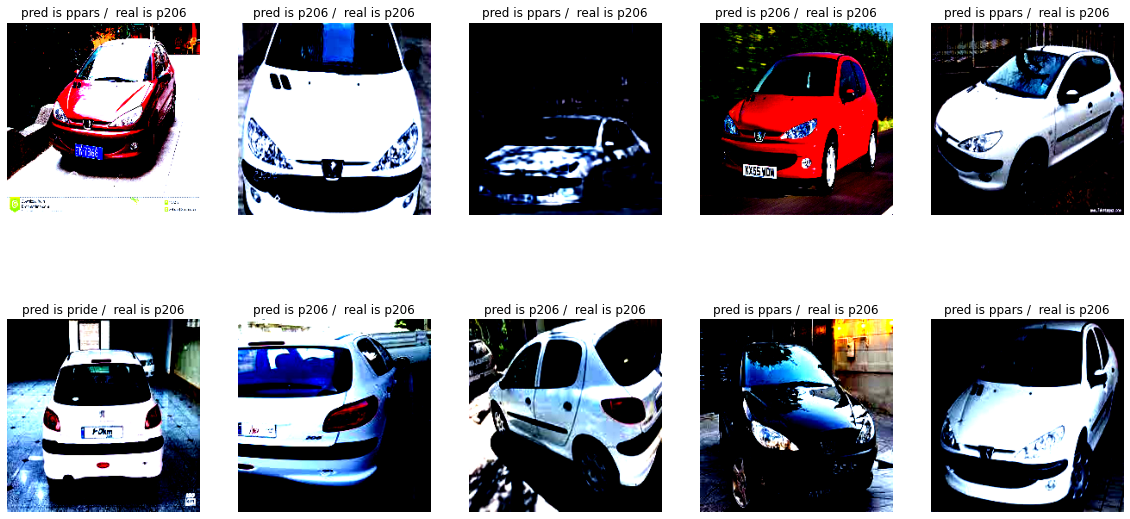

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

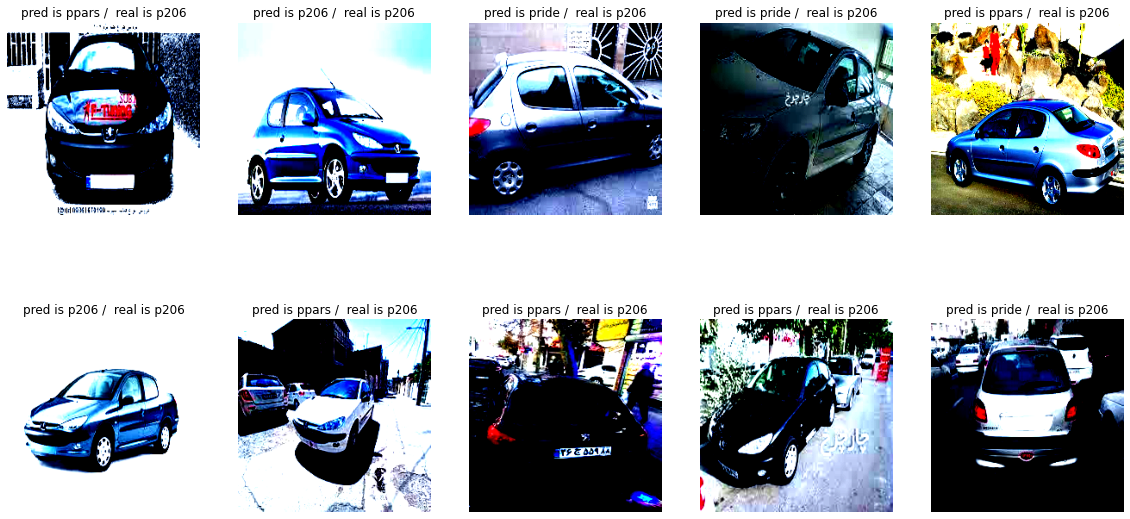

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

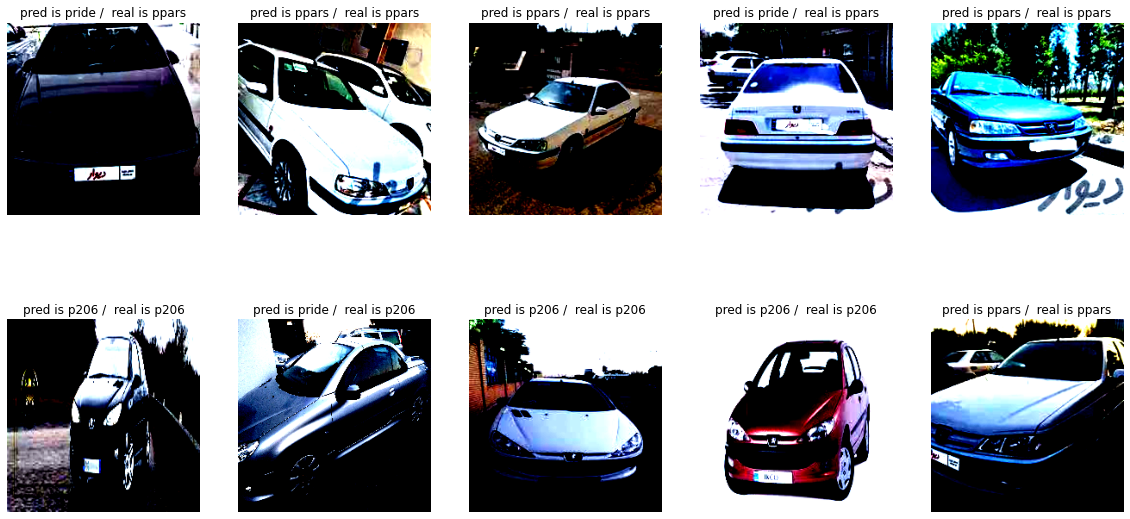

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

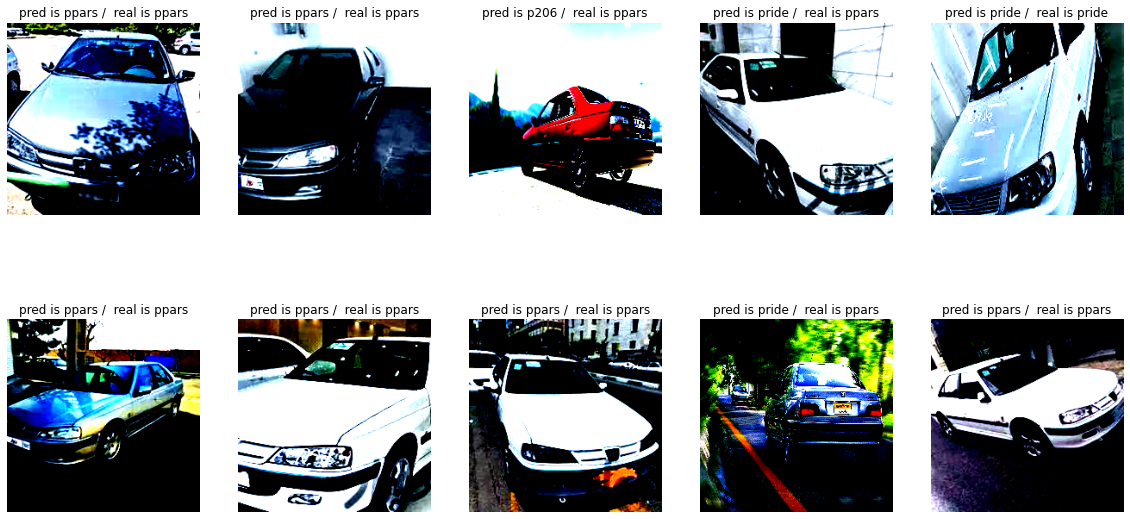

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

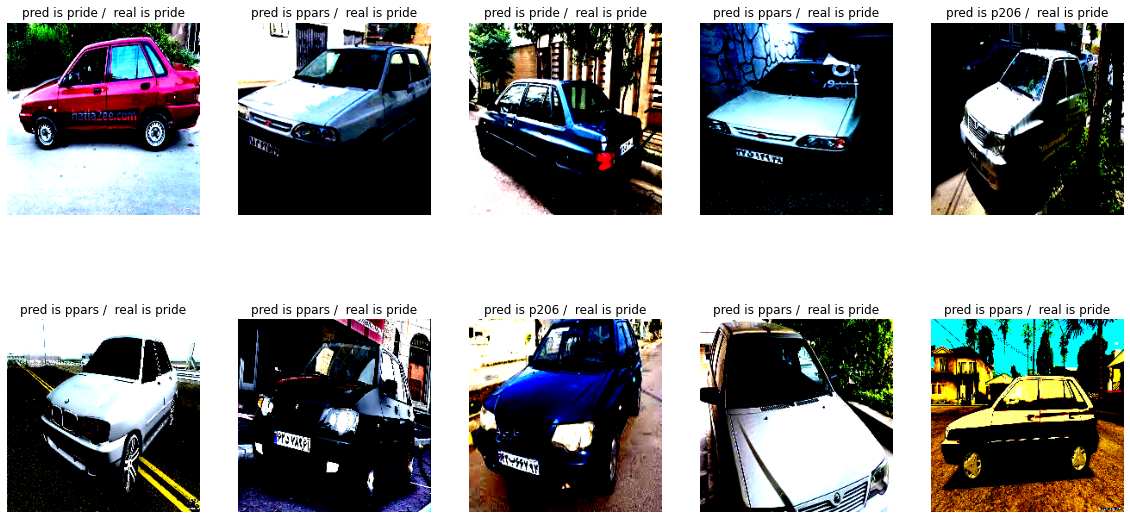

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

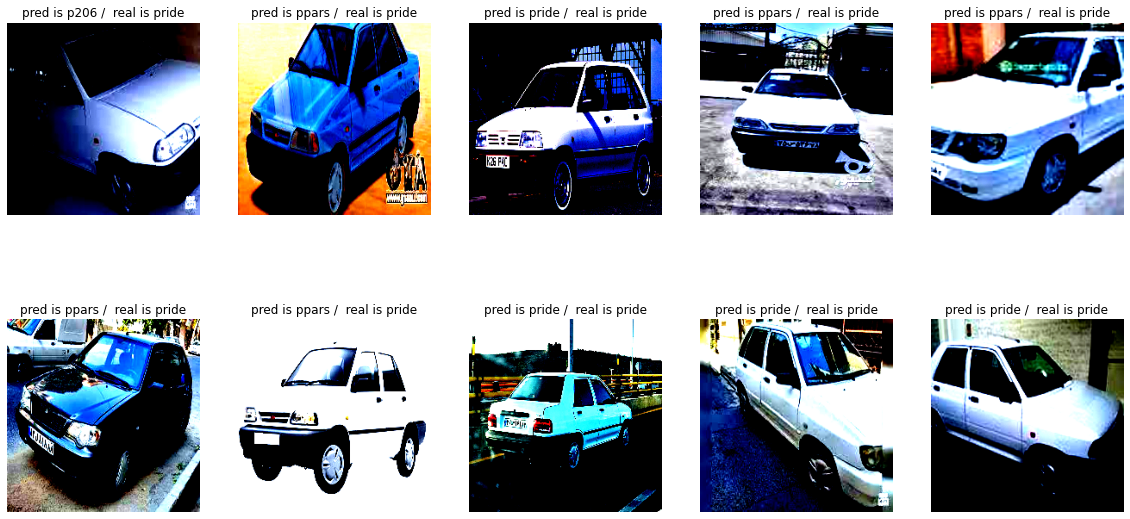

Test Accuracy: 43.33333
Accuracy of  p206 : 37 %
Accuracy of ppars : 66 %
Accuracy of pride : 33 %


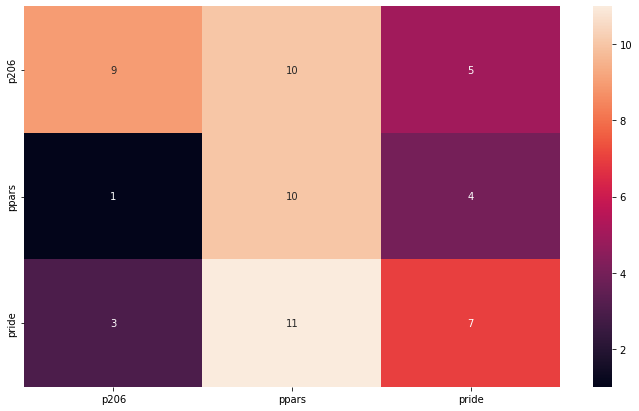

In [ ]:
predict_resnet(resnet_model, test_loader)

# Visualization

In [ ]:
#@title Helper functions
import seaborn as sns
classes = ['p206', 'ppars', 'pride']
test_image_path = "/content/drive/MyDrive/final/dataset/test"
test_image_paths, _ = get_paths(test_image_path,"test")

def classify_one_image(img_path, model,classes, encoder=None, mode= "resnet"):   ### Test a SINGLE image ###
    img = Image.open(img_path).convert('RGB')       
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    img = transform(img)[:3, :, :].unsqueeze(0)    
    plt.imshow(np.transpose(img.squeeze(0).numpy(), (1,2,0)))
    plt.show()
    model.eval()
    img = img.cuda() if use_cuda else img
    if mode == "resnet" :
      logits = model(img) # [batch, n_classes]
      _, predicted = torch.max(logits.data, 1)
      predicted = predicted.data.cpu().numpy()
      logits = logits.cpu().detach().numpy()
    else:
      embeddings, att_weights = encoder(img) 
      embedding_cls_token = embeddings[:, 0, :] 
      logits = model(embedding_cls_token) # classifier
      _, predicted = torch.max(logits.data, 1)
      predicted = predicted.data.cpu().numpy()
      logits = logits.cpu().detach().numpy()
    probs = np.array([[np.exp(l)/sum(np.exp(batch)) for l in batch] for batch in logits]).squeeze(0)
    
    plt.figure()
    f, ax = plt.subplots(figsize=(4, 2))
    sns.set_color_codes("pastel")
    logits_df = pd.DataFrame(probs, index=classes, columns=["probability"]).sort_values("probability",ascending=False)
    sns.barplot(x="probability", y=logits_df.index, data=logits_df,label="Total",color="b")
    plt.title('class probabilities')
    plt.show()
    return predicted

In [ ]:
#@title Load model
model = torch.load('/content/drive/MyDrive/final/checkpoint/resnet_best_4_50.pt')
encoder = torch.load('/content/drive/MyDrive/final/checkpoint/encoder_best_1.pt')
classifier = torch.load('/content/drive/MyDrive/final/checkpoint/classifier_best_1.pt')

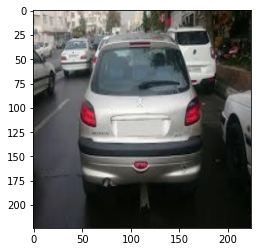

<Figure size 432x288 with 0 Axes>

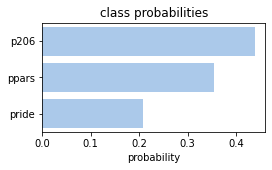

In [ ]:
#@title Classify an image
#@markdown Choose a number between 1 to 60
index =  15#@param {type:"integer"}
model_name = "resnet" #@param ["resnet", "ViT"]
if model_name == "resnet":
  res = classify_one_image(test_image_paths[index-1], model, classes, mode= "resnet")
else:
  res = classify_one_image(test_image_paths[index-1], classifier, classes,encoder, mode= "Vit")


# Counting Cars

In [ ]:
%cd '/content/drive/MyDrive/final/counts/'

/content/drive/.shortcut-targets-by-id/1gar1xzN5O-_Z_zB37DCH4wLP16YJxmKL/final/counts


In [ ]:
# !pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/drive/.shortcut-targets-by-id/1gar1xzN5O-_Z_zB37DCH4wLP16YJxmKL/final/counts/yolov5
     |████████████████████████████████| 596 kB 30.9 MB/s 


In [ ]:
root = '/content/drive/MyDrive/final/dataset_cars/'
base_root = '/content/drive/MyDrive/final/'
dataset_cars_paths = get_dataset_cars_path(root)
print("multi_car_dataset ",dataset_cars_paths)

multi_car_dataset  ['/content/drive/MyDrive/final/dataset_cars/images_8.jpeg', '/content/drive/MyDrive/final/dataset_cars/images_4.jpeg', '/content/drive/MyDrive/final/dataset_cars/images_0.jpg', '/content/drive/MyDrive/final/dataset_cars/images_3.jpeg', '/content/drive/MyDrive/final/dataset_cars/images_1.jpeg', '/content/drive/MyDrive/final/dataset_cars/images_2.jpeg', '/content/drive/MyDrive/final/dataset_cars/images_5.jpeg', '/content/drive/MyDrive/final/dataset_cars/images_6.jpeg', '/content/drive/MyDrive/final/dataset_cars/images_7.jpeg', '/content/drive/MyDrive/final/dataset_cars/images_9.jpeg', '/content/drive/MyDrive/final/dataset_cars/images_10.jpeg']


In [ ]:
old_files = glob.glob('/content/drive/My Drive/final/counts/yolov5/runs/*')
for f in old_files:
    shutil.rmtree(f)

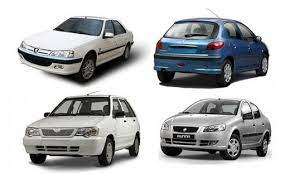

In [ ]:
from IPython.display import Image, display
display(Image('/content/drive/MyDrive/final/dataset_cars/images_8.jpeg'))

In [ ]:
# Inference
# model_for_counts = torch.hub.load('ultralytics/yolov5', 'yolov5s')
# results_for_count = model_for_counts(img)

!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --save-crop  --source '/content/drive/MyDrive/final/dataset_cars/images_8.jpeg'

detect: weights=['yolov5s.pt'], source=/content/drive/MyDrive/final/dataset_cars/images_8.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-289-g526e650 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /content/drive/.shortcut-targets-by-id/1gar1xzN5O-_Z_zB37DCH4wLP16YJxmKL/final/dataset_cars/images_8.jpeg: 384x640 4 cars, Done. (0.027s)
Speed: 0.5ms pre-process, 27.1ms inference, 42.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


In [ ]:
%cd /content/drive/My Drive/final/

/content/drive/.shortcut-targets-by-id/1gar1xzN5O-_Z_zB37DCH4wLP16YJxmKL/final


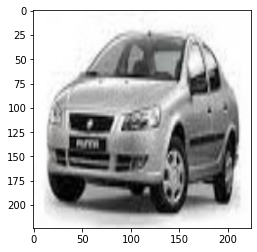

<Figure size 432x288 with 0 Axes>

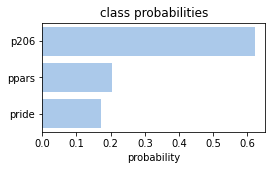

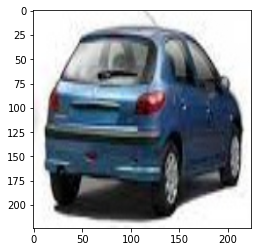

<Figure size 432x288 with 0 Axes>

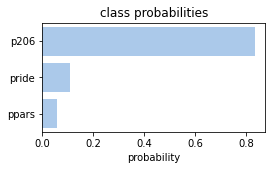

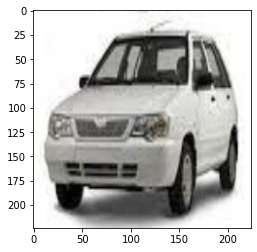

<Figure size 432x288 with 0 Axes>

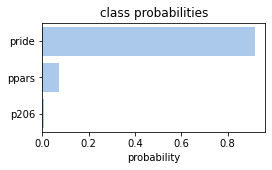

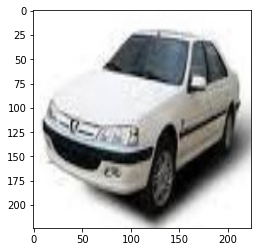

<Figure size 432x288 with 0 Axes>

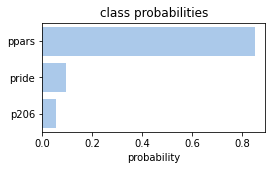

**************************************************
Number of pride is :  1
Number of ppars is :  1
Number of p206 is :  2


In [ ]:
from PIL import Image
crop_cars_path = get_crop_cars_path("/content/drive/My Drive/final/counts/yolov5/runs/detect/exp/crops/car")

counts = {
    "pride":0,
    "p206":0,
    "ppars":0,
}
for l in crop_cars_path:
  res = classify_one_image(l, classifier, classes,encoder, mode= "Vit")
  res = idx_to_class[res[0]]
  if res == "pride":
    counts["pride"] = counts.get(res) + 1
  elif res == "p206":
    counts["p206"] = counts.get(res) + 1
  else:
    counts["ppars"] = counts.get(res) + 1

print("*"*50)
print("Number of pride is : ",counts["pride"])
print("Number of ppars is : ",counts["ppars"])
print("Number of p206 is : ",counts["p206"])